<h1><center>LSTM-based MODELS</center></h1>

**LIBRARIES**  

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# fix random seed for reproducibility
tf.random.set_seed(8)

Num GPUs Available:  0


## HYPERPARAMETERS

* Saved models for later review:
    * LSTM: 7, 9
    * LSTM_DNN: 4-6 (1-3 have many errors)
    * LSTM_CNN:
    * CNN: 8

### LSTM-based

In [51]:
# Hyperparameter for LSTM
TRAIN_TEST_RATIO = 0.8
TIME_STEP = 20
MODEL_TYPE = "LSTM"
EPOCH_SIZE = 1000
BATCH_SIZE = 32 
MODEL_JSON = {}
def to_string():
    print_list = [
        f"Time step: {TIME_STEP}",
        f"Ratio: {TRAIN_TEST_RATIO}",
        f"Model type: {MODEL_TYPE}",
        f"Epoch size: {EPOCH_SIZE}",
        f"Batch size: {BATCH_SIZE}",
        f"Model json: {MODEL_JSON}",
    ]
    return "\n".join(print_list)

In [4]:
# Hyperparameter for LSTM_DNN 
TRAIN_TEST_RATIO = 0.8
TIME_STEP = 20
MODEL_TYPE = "LSTM_DNN"
EPOCH_SIZE = 1000
BATCH_SIZE = 32 
MODEL_JSON = {}
def to_string():
    print_list = [
        f"Time step: {TIME_STEP}",
        f"Ratio: {TRAIN_TEST_RATIO}",
        f"Model type: {MODEL_TYPE}",
        f"Epoch size: {EPOCH_SIZE}",
        f"Batch size: {BATCH_SIZE}",
        f"Model json: {MODEL_JSON}",
    ]
    return "\n".join(print_list)

### CNN-based

In [65]:
# Hyperparameter for CNN
TRAIN_TEST_RATIO = 0.8
TIME_STEP = 20
MODEL_TYPE = "CNN"
EPOCH_SIZE = 1000
BATCH_SIZE = 32 
MODEL_JSON = {}
def to_string():
    print_list = [
        f"Time step: {TIME_STEP}",
        f"Ratio: {TRAIN_TEST_RATIO}",
        f"Model type: {MODEL_TYPE}",
        f"Epoch size: {EPOCH_SIZE}",
        f"Batch size: {BATCH_SIZE}",
        f"Model json: {MODEL_JSON}",
    ]
    return "\n".join(print_list)

## DATA PRE-PROCESSING

(24541, 1)


<Figure size 640x480 with 0 Axes>

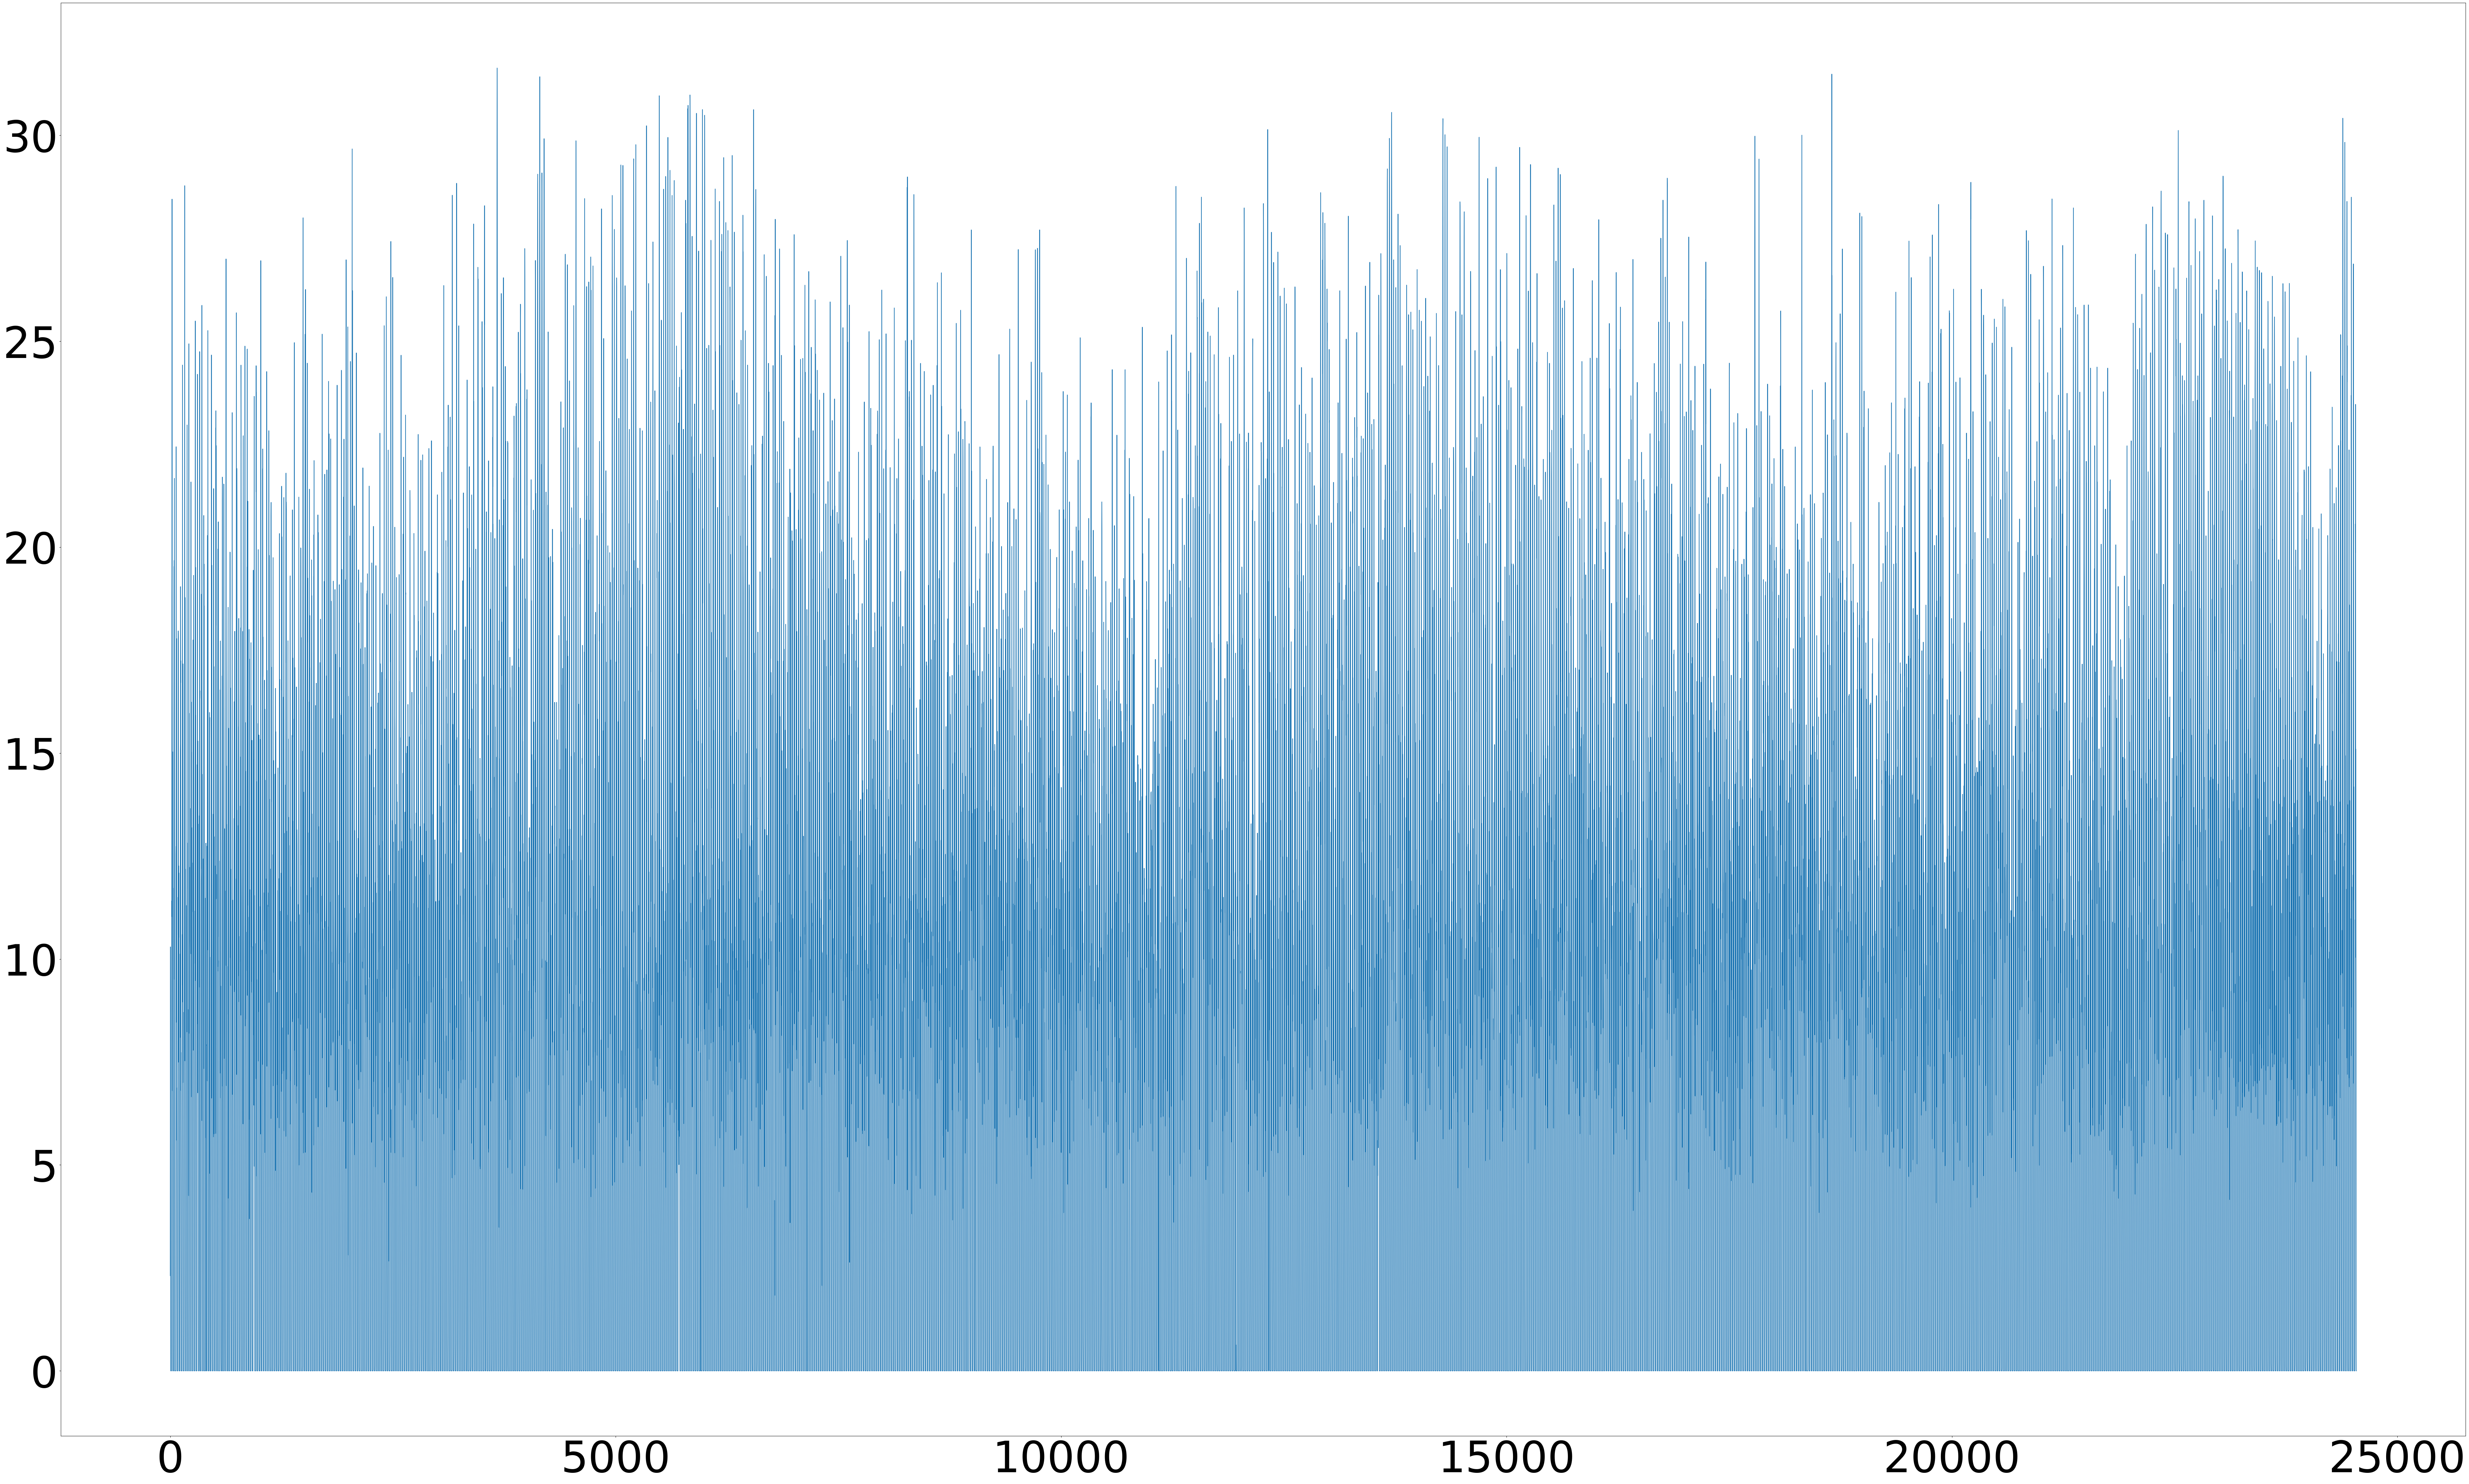

In [66]:
# dataframe = pd.read_excel('./data/Data_for_ML_TT-DB0.xlsx', sheet_name="Data", header=0, usecols=[3])
dataframe = pd.read_excel('./data/Solar_System_Master_AC-Power-(20-23).xlsx', sheet_name="AC Power", header=0, usecols=[1])
# dataframe = pd.read_excel('./data/Solar_System_Master_AC-Power-(20-23).xlsx', sheet_name="AC Power (2)", header=0, usecols=[1])
dataset = dataframe.values.astype('float64')

dataset = np.reshape(dataset, (-1, 1))

#Preprocessing: replacing all negative & NaN values in the dataset with 0
dataset[dataset<0] = 0
dataset[np.isnan(dataset)] = 0

#Plot how dataset looks like
print(dataset.shape)
plt.clf()
plt.figure(figsize=(100,60))
plt.rcParams.update({'font.size': 100})
plt.plot(dataset)
plt.show()

**1. Normalization Step:**
scaling the data to a range between 0 and 1 is a common technique used in machine learning to normalize the data. This is done to ensure that all features are on a similar scale and to prevent any one feature from dominating the others. In this case, the MinMaxScaler is used to scale the data to a range between 0 and 1 so that all features are on the same scale. This is important because the LSTM model used for time series prediction is sensitive to the scale of the input data. By scaling the data, we can ensure that the LSTM model performs well and produces accurate predictions.

In [69]:
print(dataset) # check dataset before scaling

# Create a scaler object that will scale data to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
# Use the scaler object created previously to scale our whole dataset
dataset = scaler.fit_transform(dataset)

print(dataset) # check how dataset is after scaling

[[0.07305893]
 [0.17880627]
 [0.32542994]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
[[0.07305893]
 [0.17880627]
 [0.32542994]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


**2. Data Split:**

In [71]:
# After scaling our dataset, split them into train and test sets

# Calculates the size of the training set based on the ratio of training to testing data (current ratio = 0.8)
train_size = int(len(dataset) * TRAIN_TEST_RATIO)
# Calculates the size of the testing set based on the size of the training data
test_size = len(dataset) - train_size
# Splits the dataset into training and testing sets
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

19632 4909


The function creates a dataset for time series prediction by using a sliding window approach with a fixed number of time steps. The input data is split into input (X) and output (Y) components, where X is a 3D array of shape (samples, time steps, features) and Y is a 2D array of shape (samples, features). By using a sliding window approach with a fixed number of time steps, we can ***ensure that the model has access to enough historical data to make accurate predictions***.

In [72]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# X is a 3D array of shape (samples, time steps, features) and Y is a 2D array of shape (samples, features)

In [73]:
# Reshape into X=t and Y=t+1

# Creates a dataset for training & testing by using a sliding window approach with a fixed number of time steps
trainX, trainY = create_dataset(train, TIME_STEP)
testX, testY = create_dataset(test, TIME_STEP)

print(trainX.shape)
print(testX.shape)

(19611, 20)
(4888, 20)


In [75]:
# Reshape input to be [samples, time steps, features]

# Reshape training & testing data to be compatible with the input shape of the LSTM model
trainX = np.reshape(trainX, (trainX.shape[0], TIME_STEP, 1))
testX = np.reshape(testX, (testX.shape[0], TIME_STEP, 1))

print(trainX.shape)
print(testX.shape)

(19611, 20, 1)
(4888, 20, 1)


## TRAINING MODELS

Depending on the model type input in the Hyperparameters section at the beginning, it will add different layers for different model types

In [76]:
# Create and fit the LSTM network for time series prediction

# Creates an early stopping callback that stops training when the loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                min_delta=0.00001, 
                                patience=10, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)

# Creates a log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Creates a TensorBoard callback that logs the training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Create sequential model
model = Sequential()
# Check the model type and adds the appropriate layers to the model.
if MODEL_TYPE == "LSTM":
    # Adds an LSTM layer with 32 units to the model
    model.add(LSTM(32, input_shape=(TIME_STEP, 1), return_sequences=True))
    # Adds another LSTM layer with 32 units to the model
    model.add(LSTM(32, input_shape=(TIME_STEP, 1)))
    # Adds a dense layer with one unit to the model
    model.add(Dense(1)) 
# Add layers to the model for other different model types
elif MODEL_TYPE == "CNN":
    model.add(Conv1D(32, (3), activation='relu', input_shape=(TIME_STEP,1)))
    # model.add(layers.MaxPooling1D((2)))
    model.add(Conv1D(64, (3), activation='relu'))
    # model.add(layers.MaxPooling1D((2)))
    model.add(Conv1D(64, (3), activation='relu'))
    model.add(MaxPooling1D((2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM":
    model.add(
        Conv1D(6, (3), activation="relu", input_shape=(TIME_STEP, 1))
    )
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM_DNN":
    model.add(
        Conv1D(64, (5), activation="relu", input_shape=(TIME_STEP, 1))
    )
    model.add(
        LSTM(
            32, "relu", input_shape=(TIME_STEP, 1), return_sequences=True
        )
    )
    model.add(LSTM(32, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN":
    model.add(
        LSTM(
            32, "relu", input_shape=(TIME_STEP, 1), return_sequences=True
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            32, "relu", input_shape=(TIME_STEP, 1), return_sequences=True
        )
    )
    model.add(LSTM(32, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN2":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(16))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN3":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1), return_sequences=True))
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN4":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN5":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(1))
model.summary()
MODEL_JSON = model.to_json()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, verbose=2, callbacks=[early_stopping, tensorboard_callback])
%tensorboard --logdir logs/fit

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 18, 32)            128       
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 64)            6208      
                                                                 
 conv1d_5 (Conv1D)           (None, 14, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 448)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                28736     
                                                      

UsageError: Line magic function `%tensorboard` not found.


In [77]:
# Save model
version = 0
for dir in os.scandir(f"./Saved Model/"):
    if dir.is_dir():
        version = int(dir.name) if int(dir.name) > version else version
version += 1
model.save(f"./Saved Model/{version}")

INFO:tensorflow:Assets written to: ./Saved Model/10\assets


INFO:tensorflow:Assets written to: ./Saved Model/10\assets


## PREDICTION

### SCORES
1. **RMSE (Root Mean Squared Error):** 
    * Lower RMSE values are generally better. A lower RMSE indicates that your model's predictions are closer to the true values.
    * However, whether a particular RMSE is good or not depends on the scale of your data. 
2. **RMSPE (Root Mean Squared Percentage Error):** usually expressed as a percentage
3. **MAE (Mean Absolute Error):** lower MAE values are better. MAE measures the average magnitude of errors, and a lower MAE indicates that the model's predictions are closer to the true values.
4. **MAPE (Mean Absolute Percentage Error):** the average percentage difference between predictions and their intended targets in the dataset. *The lower the value for MAPE, the better the machine learning model* is at predicting values.

#### Approach 1
The condition to use this approach is to get rid of all zero values in the data (negatives values will be removed depending on each case)

In [45]:
# Make predictions on training & testing data
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Invert predictions
# train_predict = scaler.inverse_transform(train_predict)
# train_true = scaler.inverse_transform([trainY])
# test_predict = scaler.inverse_transform(test_predict)
# test_true = scaler.inverse_transform([testY])
train_predict = train_predict
train_true = np.reshape(trainY,(1,-1))
test_predict = test_predict
test_true = np.reshape(testY,(1,-1))

# Calculate root mean squared error (RMSE) - Approach 1
trainScore = np.sqrt(mean_squared_error(train_true[0], train_predict[:, 0]))
train_score_percentage = np.sqrt(
    np.mean(
        np.square(((train_true[0] - train_predict[:, 0]) / train_true[0])),
        axis=0,
    )
)
test_score_percentage = np.sqrt(
    np.mean(
        np.square(((test_true[0] - test_predict[:, 0]) / test_true[0])),
        axis=0,
    )
)
train_score_percentage_output = (
    "Train RMSPE: %.4f RMSPE" % train_score_percentage
)
test_score_percentage_output = "Test RMSPE: %.4f RMSPE" % test_score_percentage
train_score_output = "Train Score: %.4f RMSE" % (trainScore)
testScore = np.sqrt(mean_squared_error(test_true[0], test_predict[:, 0]))
test_score_output = "Test Score: %.4f RMSE" % (testScore)
print(train_score_output)
print(test_score_output)
print(train_score_percentage_output)
print(test_score_percentage_output)


# Calculate MAE 
from sklearn.metrics import mean_absolute_error as mae
trainScore_mae = mae(train_true[0], train_predict[:, 0])
testScore_mae = mae(test_true[0], test_predict[:, 0])
train_mae_output = "Train MAE: %.4f MAE" % (trainScore_mae)
test_mae_output = "Test MAE: %.4f MAE" % (testScore_mae)
print(train_mae_output)
print(test_mae_output)

# Save results into info.md of each Model has been run for later check
rmse_file = open(
    f"./Saved Model/{version}/info.md", "w"
)
rmse_file.write(
    train_score_output
    + "\n"
    + test_score_output
    + "\n"
    + train_score_percentage_output
    + "\n"
    + test_score_percentage_output
    + "\n"
    + train_mae_output
    + "\n"
    + test_mae_output
    + "\n"
    + to_string()
)
rmse_file.close()


81/81 [==============================] - 0s 5ms/step
Train Score: 0.0348 RMSE
Test Score: 0.1790 RMSE
Train RMSPE: inf RMSPE
Test RMSPE: 99.4878 RMSPE
Train MAE: 0.0273 MAE
Test MAE: 0.1410 MAE


C:\Users\Nhan Duong\AppData\Local\Temp\ipykernel_24956\1664186359.py:19: RuntimeWarning: divide by zero encountered in divide
  np.square(((train_true[0] - train_predict[:, 0]) / train_true[0])),


#### Approach 2
This is the 2nd approach for calculating RMSPE by adding a small constant (e.g., 1e-6) to the denominator to prevent division by zero. Run this approach only **when the data contains 0** *OR* **the result is still = "inf" but there are no zero values left in the data** 

In [78]:
# Make predictions on training & testing data
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Invert predictions
# train_predict = scaler.inverse_transform(train_predict)
# train_true = scaler.inverse_transform([trainY])
# test_predict = scaler.inverse_transform(test_predict)
# test_true = scaler.inverse_transform([testY])
train_predict = train_predict
train_true = np.reshape(trainY,(1,-1))
test_predict = test_predict
test_true = np.reshape(testY,(1,-1))


# Calculate Root Mean Squared Error (RMSE) - Approach 2
# RMSE & RMSPE for Training Data
train_error = train_true[0] - train_predict[:, 0]
trainScore = np.sqrt(mean_squared_error(train_true[0], train_predict[:, 0]))
train_score_percentage = np.sqrt(
    np.mean(np.square(train_error / (train_true[0] + 1e-6)))
)
#output: 
train_score_output = "Train Score: %.4f RMSE" % (trainScore)
train_score_percentage_output = (
    "Train RMSPE: %.4f RMSPE" % train_score_percentage
)

# RMSE & RMSPE for Testing Data
test_error = test_true[0] - test_predict[:, 0]
testScore = np.sqrt(mean_squared_error(test_true[0], test_predict[:, 0]))
test_score_percentage = np.sqrt(
    np.mean(np.square(test_error / (test_true[0] + 1e-6)))
)
#output: 
test_score_percentage_output = "Test RMSPE: %.4f RMSPE" % test_score_percentage
test_score_output = "Test Score: %.4f RMSE" % (testScore)

print(train_score_output)
print(test_score_output)
print(train_score_percentage_output)
print(test_score_percentage_output)


# Calculate Mean Absolute Error (MAE) 
from sklearn.metrics import mean_absolute_error as mae
trainScore_mae = mae(train_true[0], train_predict[:, 0])
testScore_mae = mae(test_true[0], test_predict[:, 0])
train_mae_output = "Train MAE: %.4f MAE" % (trainScore_mae)
test_mae_output = "Test MAE: %.4f MAE" % (testScore_mae)
print(train_mae_output)
print(test_mae_output)


# Calculate Mean Absolute Percentage Error (MAPE):
# Calculate the absolute percentage errors
train_absolute_percentage_error = np.abs(train_error / (train_true[0] + 1e-6))
test_absolute_percentage_error = np.abs(test_error / (test_true[0] + 1e-6))
# Calculate the mean of the absolute percentage errors
train_mape = np.mean(train_absolute_percentage_error)
test_mape = np.mean(test_absolute_percentage_error)
# Format the results as strings
train_mape_output = "Train MAPE: %.4f MAPE" % (train_mape * 100)
test_mape_output = "Test MAPE: %.4f MAPE" % (test_mape * 100)
print(train_mape_output)
print(test_mape_output)


# Save results into info.md of each Model has been run for later check
rmse_file = open(
    f"./Saved Model/{version}/info.md", "w"
)
rmse_file.write(
    train_score_output
    + "\n"
    + test_score_output
    + "\n"
    + train_score_percentage_output
    + "\n"
    + test_score_percentage_output
    + "\n"
    + train_mae_output
    + "\n"
    + test_mae_output
    + "\n"
    + train_mape_output
    + "\n"
    + test_mape_output
    + "\n"
    + to_string()
)
rmse_file.close()

153/153 [==============================] - 1s 5ms/step
Train Score: 0.0312 RMSE
Test Score: 0.1299 RMSE
Train RMSPE: 8256.3388 RMSPE
Test RMSPE: 22616.7137 RMSPE
Train MAE: 0.0207 MAE
Test MAE: 0.0772 MAE
Train MAPE: 390965.9247 MAPE
Test MAPE: 600310.1950 MAPE


### PLOT

<Figure size 640x480 with 0 Axes>

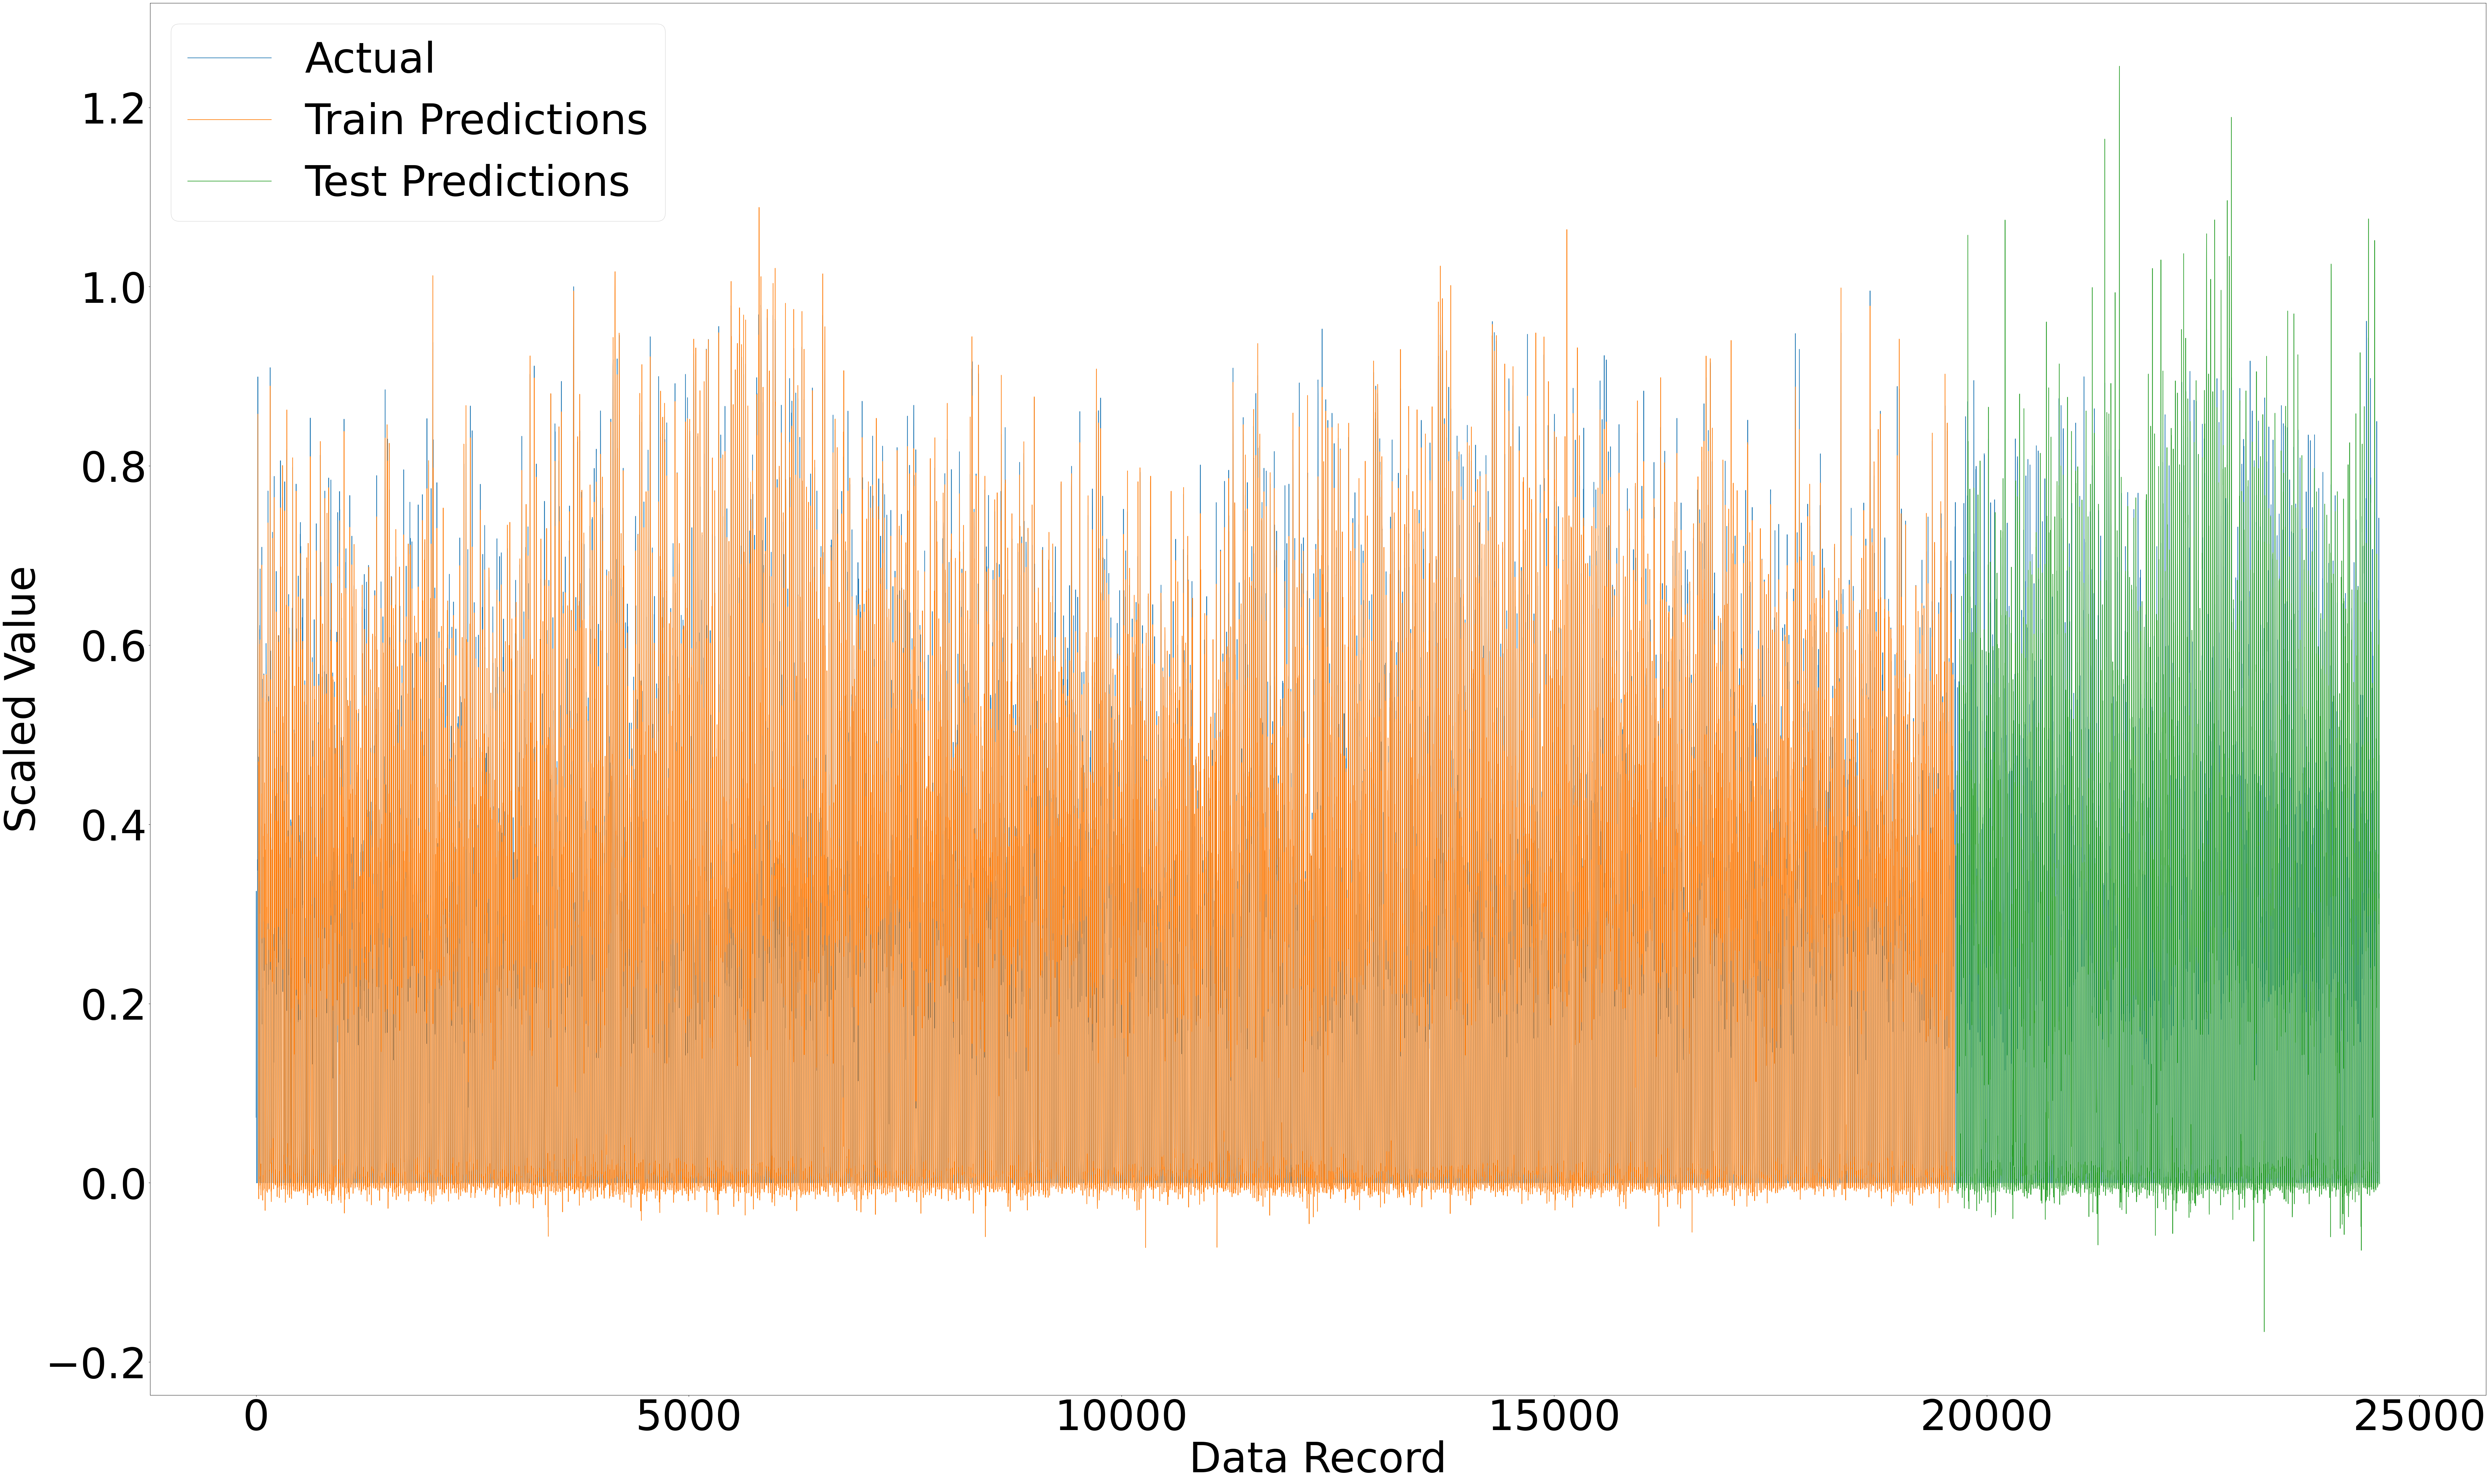

In [81]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[TIME_STEP:len(train_predict)+TIME_STEP, :] = train_predict
# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(TIME_STEP*2)+1:len(dataset)-1, :] = test_predict
# Plot baseline and predictions
plt.clf()
plt.figure(figsize=(100,60))
plt.rcParams.update({'font.size': 100})
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')

# Add axis labels and legend
plt.xlabel('Data Record')
plt.ylabel('Scaled Value')
plt.legend(['Actual', 'Train Predictions', 'Test Predictions'])

# Save the plot to a file
plt.savefig(f"Saved Model/{version}/predict.png")

plt.show()